# Notebook 06: Full Area Inference - All Models Comparison

**Mục đích:** Chạy inference cho TẤT CẢ models (Random Forest + Simple CNN) và so sánh kết quả side-by-side.

**Input:**
- Random Forest model (trained)
- Simple CNN model (trained)
- Full Sentinel-1 và Sentinel-2 imagery
- Forest boundary shapefile

**Output:**
- Probability maps cho cả 2 models (GeoTIFF)
- Binary maps cho cả 2 models (GeoTIFF)
- Difference map (CNN - RF)
- Agreement/Disagreement statistics
- Side-by-side comparison visualizations

**Thời gian ước tính:** ~45-90 phút (inference cho 2 models)

---

## Pipeline:
1. Load cả 2 models (RF + CNN)
2. Load full imagery
3. Run inference cho Random Forest
4. Run inference cho Simple CNN
5. Compare probability maps
6. Calculate agreement/disagreement
7. Visualize side-by-side
8. Export all results

In [1]:
# Import libraries
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import pickle
import json
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from pathlib import Path

from src.config import *
from src.models import SimpleCNN
from src.feature_extraction import extract_patch_features
from src.utils import read_geotiff, validate_sentinel2_ranges, normalize_image, mask_raster_with_boundary

plt.style.use('default')
%matplotlib inline

## 1. Load All Models

In [2]:
print("="*70)
print("LOADING ALL MODELS")
print("="*70)

models = {}

# Load Random Forest
rf_path = MODELS_DIR / "random_forest_baseline.pkl"
if rf_path.exists():
    with open(rf_path, 'rb') as f:
        models['rf'] = pickle.load(f)
    print(f"\n✓ Random Forest loaded from {rf_path}")
    print(f"  - n_estimators: {models['rf'].n_estimators}")
    print(f"  - max_depth: {models['rf'].max_depth}")
else:
    print(f"\n✗ Random Forest not found at {rf_path}")
    print("  Please train Random Forest first (notebook 03)!")

# Load Simple CNN
cnn_path = MODELS_DIR / "simple_cnn_best.pth"
if cnn_path.exists():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n✓ Using device: {device}")
    
    model_cnn = SimpleCNN(in_channels=TOTAL_INPUT_CHANNELS, num_classes=NUM_CLASSES)
    checkpoint = torch.load(cnn_path, map_location=device, weights_only=False)
    model_cnn.load_state_dict(checkpoint['model_state_dict'])
    model_cnn = model_cnn.to(device)
    model_cnn.eval()
    models['cnn'] = model_cnn
    
    print(f"✓ Simple CNN loaded from {cnn_path}")
    print(f"  - Best epoch: {checkpoint['epoch']+1}")
    print(f"  - Val accuracy: {checkpoint['val_acc']:.4f}")
else:
    print(f"\n✗ Simple CNN not found at {cnn_path}")
    print("  Please train Simple CNN first (notebook 04)!")

# Check if both models loaded
if 'rf' in models and 'cnn' in models:
    print("\n" + "="*70)
    print("✓ Both models loaded successfully!")
    print("="*70)
else:
    print("\n❌ Cannot proceed without both models.")

LOADING ALL MODELS

✓ Random Forest loaded from d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\models\random_forest_baseline.pkl
  - n_estimators: 500
  - max_depth: 20

✓ Using device: cuda
✓ Simple CNN loaded from d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\models\simple_cnn_best.pth
  - Best epoch: 25
  - Val accuracy: 0.9635

✓ Both models loaded successfully!


## 2. Load Phase 1 Comparison Results

In [3]:
# Load comparison for reference
comparison_file = RESULTS_DIR / "phase1_comparison.json"

if comparison_file.exists():
    with open(comparison_file, 'r') as f:
        comparison = json.load(f)
    
    print("="*70)
    print("PHASE 1 TEST SET RESULTS (Reference)")
    print("="*70)
    
    if 'rf' in comparison and 'cnn' in comparison:
        print(f"\nRandom Forest:")
        print(f"  - Accuracy:  {comparison['rf']['accuracy']:.4f}")
        print(f"  - Precision: {comparison['rf']['precision']:.4f}")
        print(f"  - Recall:    {comparison['rf']['recall']:.4f}")
        print(f"  - F1-Score:  {comparison['rf']['f1']:.4f}")
        
        print(f"\nSimple CNN:")
        print(f"  - Accuracy:  {comparison['cnn']['accuracy']:.4f}")
        print(f"  - Precision: {comparison['cnn']['precision']:.4f}")
        print(f"  - Recall:    {comparison['cnn']['recall']:.4f}")
        print(f"  - F1-Score:  {comparison['cnn']['f1']:.4f}")
        
        print(f"\nWinner: {comparison.get('winner', 'N/A')}")
else:
    print("⚠️ Phase 1 comparison not found. Skipping reference metrics.")

PHASE 1 TEST SET RESULTS (Reference)

Random Forest:
  - Accuracy:  0.8854
  - Precision: 0.8476
  - Recall:    0.9368
  - F1-Score:  0.8900

Simple CNN:
  - Accuracy:  0.9688
  - Precision: 0.9677
  - Recall:    0.9677
  - F1-Score:  0.9677

Winner: Simple CNN


## 3. Load Full Area Imagery

In [4]:
print("\n" + "="*70)
print("LOADING FULL AREA IMAGERY")
print("="*70)

# Load Sentinel-2
print("\n[1/4] Loading Sentinel-2 2024...")
s2_2024, profile_s2, transform = read_geotiff(SENTINEL2_2024, clip_sentinel2=True)
print(f"  Shape: {s2_2024.shape}")

print("[2/4] Loading Sentinel-2 2025...")
s2_2025, _, _ = read_geotiff(SENTINEL2_2025, clip_sentinel2=True)
print(f"  Shape: {s2_2025.shape}")

# Load Sentinel-1
print("[3/4] Loading Sentinel-1 2024...")
s1_2024, _, _ = read_geotiff(SENTINEL1_2024)
s1_2024 = s1_2024[0:2, :, :]  # VV, VH
print(f"  Shape: {s1_2024.shape}")

print("[4/4] Loading Sentinel-1 2025...")
s1_2025, _, _ = read_geotiff(SENTINEL1_2025)
s1_2025 = s1_2025[0:2, :, :]
print(f"  Shape: {s1_2025.shape}")

# Get dimensions
height, width = s2_2024.shape[1], s2_2024.shape[2]
print(f"\n✓ Imagery loaded successfully")
print(f"  Full area dimensions: {height} × {width} pixels")
print(f"  Resolution: 10m/pixel")
print(f"  Total area: {(height * 10 / 1000) * (width * 10 / 1000):.2f} km²")


LOADING FULL AREA IMAGERY

[1/4] Loading Sentinel-2 2024...
  Shape: (7, 10917, 12547)
[2/4] Loading Sentinel-2 2025...
  Shape: (7, 10917, 12547)
[3/4] Loading Sentinel-1 2024...
  Shape: (2, 10917, 12547)
[4/4] Loading Sentinel-1 2025...
  Shape: (2, 10917, 12547)

✓ Imagery loaded successfully
  Full area dimensions: 10917 × 12547 pixels
  Resolution: 10m/pixel
  Total area: 13697.56 km²


## 4. Preprocessing

In [5]:
print("\n" + "="*70)
print("PREPROCESSING")
print("="*70)

# Apply boundary mask
print("\n[1/3] Applying forest boundary mask...")
s2_2024, forest_mask = mask_raster_with_boundary(s2_2024, transform, FOREST_BOUNDARY)
s2_2025, _ = mask_raster_with_boundary(s2_2025, transform, FOREST_BOUNDARY)
s1_2024, _ = mask_raster_with_boundary(s1_2024, transform, FOREST_BOUNDARY)
s1_2025, _ = mask_raster_with_boundary(s1_2025, transform, FOREST_BOUNDARY)

forest_pixels = np.sum(forest_mask)
print(f"  Forest area: {forest_pixels:,} pixels ({forest_pixels * 100 / 1e6:.2f} km²)")

# Normalize
print("[2/3] Normalizing Sentinel-2...")
s2_2024 = validate_sentinel2_ranges(s2_2024)
s2_2025 = validate_sentinel2_ranges(s2_2025)

print("[3/3] Normalizing Sentinel-1...")
s1_2024 = normalize_image(s1_2024, method="minmax")
s1_2025 = normalize_image(s1_2025, method="minmax")

print("\n✓ Preprocessing completed")


PREPROCESSING

[1/3] Applying forest boundary mask...


c:\tools\Anaconda3\envs\dang\Lib\site-packages\rasterio\features.py:336: ShapeSkipWarning: Invalid or empty shape None at index 12 will not be rasterized.
  warnings.warn(
c:\tools\Anaconda3\envs\dang\Lib\site-packages\rasterio\features.py:336: ShapeSkipWarning: Invalid or empty shape None at index 54 will not be rasterized.
  warnings.warn(
c:\tools\Anaconda3\envs\dang\Lib\site-packages\rasterio\features.py:336: ShapeSkipWarning: Invalid or empty shape None at index 83 will not be rasterized.
  warnings.warn(
c:\tools\Anaconda3\envs\dang\Lib\site-packages\rasterio\features.py:336: ShapeSkipWarning: Invalid or empty shape None at index 97 will not be rasterized.
  warnings.warn(
c:\tools\Anaconda3\envs\dang\Lib\site-packages\rasterio\features.py:336: ShapeSkipWarning: Invalid or empty shape None at index 12 will not be rasterized.
  warnings.warn(
c:\tools\Anaconda3\envs\dang\Lib\site-packages\rasterio\features.py:336: ShapeSkipWarning: Invalid or empty shape None at index 54 will not 

  Forest area: 17,016,424 pixels (1701.64 km²)
[2/3] Normalizing Sentinel-2...
[3/3] Normalizing Sentinel-1...

✓ Preprocessing completed


## 5. Sliding Window Inference Function

In [6]:
def sliding_window_inference(s1_2024, s1_2025, s2_2024, s2_2025, forest_mask, model, model_type,
                             patch_size=64, stride=32, batch_size=16, use_hard_classification=False):
    """
    Sliding window inference over full area.
    
    Args:
        model_type: 'rf' or 'cnn'
        use_hard_classification: If True, output direct class {0,1}. If False, output probability [0,1]
    
    Returns:
        If use_hard_classification=True:
            class_map: (H, W) array of class predictions {0, 1}
            count_map: (H, W) array of prediction counts per pixel
        If use_hard_classification=False:
            probability_map: (H, W) array of deforestation probabilities [0, 1]
            count_map: (H, W) array of prediction counts per pixel
    """
    height, width = s2_2024.shape[1], s2_2024.shape[2]
    
    # Initialize output maps
    if use_hard_classification:
        # For hard classification: store class votes
        class_votes_map = np.zeros((height, width), dtype=np.int32)  # Sum of class predictions
        count_map = np.zeros((height, width), dtype=np.int16)
    else:
        # For soft classification: store probabilities
        probability_map = np.zeros((height, width), dtype=np.float32)
        count_map = np.zeros((height, width), dtype=np.int16)
    
    # Calculate number of windows
    n_rows = (height - patch_size) // stride + 1
    n_cols = (width - patch_size) // stride + 1
    total_windows = n_rows * n_cols
    
    classification_type = "HARD" if use_hard_classification else "SOFT"
    print(f"\nInference configuration ({model_type.upper()} - {classification_type}):")
    print(f"  Patch size: {patch_size}×{patch_size}")
    print(f"  Stride: {stride}")
    print(f"  Windows: {n_rows} × {n_cols} = {total_windows:,}")
    print(f"  Batch size: {batch_size}")
    print(f"  Classification: {'Hard (direct binary)' if use_hard_classification else 'Soft (probability)'}")
    print(f"\nStarting {model_type.upper()} inference...\n")
    
    # Batch processing
    patches_batch = []
    positions_batch = []
    
    if model_type == 'cnn':
        device = next(model.parameters()).device
    
    with tqdm(total=total_windows, desc=f"{model_type.upper()} {classification_type}") as pbar:
        for row_idx in range(n_rows):
            row_start = row_idx * stride
            row_end = row_start + patch_size
            
            for col_idx in range(n_cols):
                col_start = col_idx * stride
                col_end = col_start + patch_size
                
                # Check if patch is within forest
                patch_mask = forest_mask[row_start:row_end, col_start:col_end]
                if np.sum(patch_mask) < (patch_size * patch_size * 0.1):  # Skip if <10% forest
                    pbar.update(1)
                    continue
                
                # Extract patch
                s2_2024_patch = s2_2024[:, row_start:row_end, col_start:col_end]
                s1_2024_patch = s1_2024[:, row_start:row_end, col_start:col_end]
                s2_2025_patch = s2_2025[:, row_start:row_end, col_start:col_end]
                s1_2025_patch = s1_2025[:, row_start:row_end, col_start:col_end]
                
                # Check for valid data
                if (np.any(np.isnan(s2_2024_patch)) or np.any(np.isnan(s2_2025_patch)) or
                    np.any(np.isnan(s1_2024_patch)) or np.any(np.isnan(s1_2025_patch))):
                    pbar.update(1)
                    continue
                
                # Stack channels
                patch = np.concatenate([
                    s2_2024_patch,
                    s1_2024_patch,
                    s2_2025_patch,
                    s1_2025_patch
                ], axis=0)  # (18, 64, 64)
                
                patches_batch.append(patch)
                positions_batch.append((row_start, row_end, col_start, col_end))
                
                # Process batch
                if len(patches_batch) >= batch_size:
                    # Predict
                    if use_hard_classification:
                        # HARD CLASSIFICATION: Direct binary output
                        if model_type == 'cnn':
                            patches_tensor = torch.from_numpy(np.array(patches_batch)).float().to(device)
                            with torch.no_grad():
                                outputs = model(patches_tensor)
                                classes = torch.argmax(outputs, dim=1).cpu().numpy()  # Direct class
                        else:  # Random Forest
                            features_list = [extract_patch_features(p) for p in patches_batch]
                            features_array = np.array(features_list)
                            classes = model.predict(features_array)  # Direct class
                        
                        # Update class votes map
                        for cls, (r_start, r_end, c_start, c_end) in zip(classes, positions_batch):
                            class_votes_map[r_start:r_end, c_start:c_end] += cls  # Add 0 or 1
                            count_map[r_start:r_end, c_start:c_end] += 1
                    else:
                        # SOFT CLASSIFICATION: Probability output
                        if model_type == 'cnn':
                            patches_tensor = torch.from_numpy(np.array(patches_batch)).float().to(device)
                            with torch.no_grad():
                                outputs = model(patches_tensor)
                                probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Prob of class 1
                        else:  # Random Forest
                            features_list = [extract_patch_features(p) for p in patches_batch]
                            features_array = np.array(features_list)
                            probs = model.predict_proba(features_array)[:, 1]
                        
                        # Update probability map
                        for prob, (r_start, r_end, c_start, c_end) in zip(probs, positions_batch):
                            probability_map[r_start:r_end, c_start:c_end] += prob
                            count_map[r_start:r_end, c_start:c_end] += 1
                    
                    # Clear batch
                    patches_batch = []
                    positions_batch = []
                    pbar.update(batch_size)
        
        # Process remaining patches
        if len(patches_batch) > 0:
            if use_hard_classification:
                # HARD CLASSIFICATION
                if model_type == 'cnn':
                    patches_tensor = torch.from_numpy(np.array(patches_batch)).float().to(device)
                    with torch.no_grad():
                        outputs = model(patches_tensor)
                        classes = torch.argmax(outputs, dim=1).cpu().numpy()
                else:
                    features_list = [extract_patch_features(p) for p in patches_batch]
                    features_array = np.array(features_list)
                    classes = model.predict(features_array)
                
                for cls, (r_start, r_end, c_start, c_end) in zip(classes, positions_batch):
                    class_votes_map[r_start:r_end, c_start:c_end] += cls
                    count_map[r_start:r_end, c_start:c_end] += 1
            else:
                # SOFT CLASSIFICATION
                if model_type == 'cnn':
                    patches_tensor = torch.from_numpy(np.array(patches_batch)).float().to(device)
                    with torch.no_grad():
                        outputs = model(patches_tensor)
                        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
                else:
                    features_list = [extract_patch_features(p) for p in patches_batch]
                    features_array = np.array(features_list)
                    probs = model.predict_proba(features_array)[:, 1]
                
                for prob, (r_start, r_end, c_start, c_end) in zip(probs, positions_batch):
                    probability_map[r_start:r_end, c_start:c_end] += prob
                    count_map[r_start:r_end, c_start:c_end] += 1
            
            pbar.update(len(patches_batch))
    
    # Aggregate overlapping predictions
    if use_hard_classification:
        # For hard: majority voting (if sum/count >= 0.5 → class 1)
        class_map = np.zeros((height, width), dtype=np.uint8)
        class_map = np.divide(class_votes_map, count_map, 
                              out=np.zeros_like(class_votes_map, dtype=np.float32), 
                              where=count_map!=0)
        class_map = (class_map >= 0.5).astype(np.uint8)  # Majority vote
        
        # Apply forest mask
        class_map[~forest_mask] = 255  # NoData
        
        return class_map, count_map
    else:
        # For soft: average probabilities
        probability_map = np.divide(probability_map, count_map, 
                                     out=np.zeros_like(probability_map), 
                                     where=count_map!=0)
        
        # Apply forest mask
        probability_map[~forest_mask] = np.nan
        
        return probability_map, count_map

## 6. Run Inference for Random Forest

⏱️ **Random Forest inference thường nhanh hơn CNN (~5-15 phút)**

In [7]:
import time

if 'rf' in models:
    print("\n" + "="*70)
    print("RANDOM FOREST INFERENCE")
    print("="*70)
    
    start_time = time.time()
    
    prob_map_rf, count_map_rf = sliding_window_inference(
        s1_2024, s1_2025, s2_2024, s2_2025,
        forest_mask, models['rf'], 'rf',
        patch_size=PATCH_SIZE,
        stride=32,  # 50% overlap
        batch_size=32  # RF can handle larger batches
    )
    
    rf_time = time.time() - start_time
    
    print(f"\n✓ RF Inference completed in {rf_time/60:.2f} minutes")
    print(f"\nRF Probability map statistics:")
    print(f"  Min:  {np.nanmin(prob_map_rf):.4f}")
    print(f"  Max:  {np.nanmax(prob_map_rf):.4f}")
    print(f"  Mean: {np.nanmean(prob_map_rf):.4f}")
    print(f"  Std:  {np.nanstd(prob_map_rf):.4f}")
else:
    print("\n❌ Random Forest model not loaded. Skipping RF inference.")


RANDOM FOREST INFERENCE

Inference configuration (RF - SOFT):
  Patch size: 64×64
  Stride: 32
  Windows: 340 × 391 = 132,940
  Batch size: 32
  Classification: Soft (probability)

Starting RF inference...



RF SOFT:   0%|          | 0/132940 [00:00<?, ?it/s][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.0s finished
RF SOFT:   1%|          | 1659/132940 [00:00<00:19, 6577.35it/s][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.0s finished
RF SOFT:   2%|▏         | 2447/132940 [00:00<00:25, 5037.20it/s][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


✓ RF Inference completed in 2.20 minutes

RF Probability map statistics:
  Min:  0.0000
  Max:  0.9959
  Mean: 0.4521
  Std:  0.2726


## 7. Run Inference for Simple CNN

⏱️ **CNN inference có thể mất ~20-40 phút trên GPU**

In [8]:
if 'cnn' in models:
    print("\n" + "="*70)
    print("SIMPLE CNN INFERENCE")
    print("="*70)
    
    start_time = time.time()
    
    prob_map_cnn, count_map_cnn = sliding_window_inference(
        s1_2024, s1_2025, s2_2024, s2_2025,
        forest_mask, models['cnn'], 'cnn',
        patch_size=PATCH_SIZE,
        stride=32,  # 50% overlap
        batch_size=16  # Smaller batch for GPU memory
    )
    
    cnn_time = time.time() - start_time
    
    print(f"\n✓ CNN Inference completed in {cnn_time/60:.2f} minutes")
    print(f"\nCNN Probability map statistics:")
    print(f"  Min:  {np.nanmin(prob_map_cnn):.4f}")
    print(f"  Max:  {np.nanmax(prob_map_cnn):.4f}")
    print(f"  Mean: {np.nanmean(prob_map_cnn):.4f}")
    print(f"  Std:  {np.nanstd(prob_map_cnn):.4f}")
else:
    print("\n❌ Simple CNN model not loaded. Skipping CNN inference.")


SIMPLE CNN INFERENCE

Inference configuration (CNN - SOFT):
  Patch size: 64×64
  Stride: 32
  Windows: 340 × 391 = 132,940
  Batch size: 16
  Classification: Soft (probability)

Starting CNN inference...



CNN SOFT: 100%|██████████| 132940/132940 [00:22<00:00, 5972.28it/s]



✓ CNN Inference completed in 0.38 minutes

CNN Probability map statistics:
  Min:  0.0000
  Max:  0.9996
  Mean: 0.2042
  Std:  0.2811


## 8. Calculate Binary Maps and Statistics

In [9]:
threshold = 0.5
pixel_area_ha = 0.01  # 10m × 10m = 100m² = 0.01 ha
forest_area_pixels = np.sum(forest_mask)
forest_area_ha = forest_area_pixels * pixel_area_ha

results = {}

print("\n" + "="*70)
print("BINARY CLASSIFICATION AND STATISTICS")
print("="*70)

# Random Forest
if 'rf' in models:
    binary_map_rf = (prob_map_rf >= threshold).astype(np.uint8)
    binary_map_rf[np.isnan(prob_map_rf)] = 255  # NoData
    
    deforestation_pixels_rf = np.sum((prob_map_rf >= threshold) & forest_mask)
    deforestation_area_ha_rf = deforestation_pixels_rf * pixel_area_ha
    deforestation_pct_rf = (deforestation_pixels_rf / forest_area_pixels) * 100
    
    results['rf'] = {
        'deforestation_pixels': int(deforestation_pixels_rf),
        'deforestation_area_ha': float(deforestation_area_ha_rf),
        'deforestation_pct': float(deforestation_pct_rf),
        'inference_time_min': rf_time / 60
    }
    
    print(f"\n🌲 Random Forest:")
    print(f"  - Deforestation pixels: {deforestation_pixels_rf:,}")
    print(f"  - Deforestation area: {deforestation_area_ha_rf:.2f} ha ({deforestation_area_ha_rf/100:.2f} km²)")
    print(f"  - Percentage: {deforestation_pct_rf:.2f}%")
    print(f"  - Inference time: {rf_time/60:.2f} min")

# Simple CNN
if 'cnn' in models:
    binary_map_cnn = (prob_map_cnn >= threshold).astype(np.uint8)
    binary_map_cnn[np.isnan(prob_map_cnn)] = 255  # NoData
    
    deforestation_pixels_cnn = np.sum((prob_map_cnn >= threshold) & forest_mask)
    deforestation_area_ha_cnn = deforestation_pixels_cnn * pixel_area_ha
    deforestation_pct_cnn = (deforestation_pixels_cnn / forest_area_pixels) * 100
    
    results['cnn'] = {
        'deforestation_pixels': int(deforestation_pixels_cnn),
        'deforestation_area_ha': float(deforestation_area_ha_cnn),
        'deforestation_pct': float(deforestation_pct_cnn),
        'inference_time_min': cnn_time / 60
    }
    
    print(f"\n🧠 Simple CNN:")
    print(f"  - Deforestation pixels: {deforestation_pixels_cnn:,}")
    print(f"  - Deforestation area: {deforestation_area_ha_cnn:.2f} ha ({deforestation_area_ha_cnn/100:.2f} km²)")
    print(f"  - Percentage: {deforestation_pct_cnn:.2f}%")
    print(f"  - Inference time: {cnn_time/60:.2f} min")


BINARY CLASSIFICATION AND STATISTICS

🌲 Random Forest:
  - Deforestation pixels: 7,805,939
  - Deforestation area: 78059.39 ha (780.59 km²)
  - Percentage: 45.87%
  - Inference time: 2.20 min

🧠 Simple CNN:
  - Deforestation pixels: 2,793,611
  - Deforestation area: 27936.11 ha (279.36 km²)
  - Percentage: 16.42%
  - Inference time: 0.38 min


## 9. Calculate Agreement/Disagreement

In [10]:
if 'rf' in models and 'cnn' in models:
    print("\n" + "="*70)
    print("AGREEMENT/DISAGREEMENT ANALYSIS")
    print("="*70)
    
    # Calculate difference map
    diff_map = prob_map_cnn - prob_map_rf
    
    # Agreement on binary classification
    agree_both_no_def = ((binary_map_rf == 0) & (binary_map_cnn == 0) & forest_mask).sum()
    agree_both_def = ((binary_map_rf == 1) & (binary_map_cnn == 1) & forest_mask).sum()
    disagree_rf_no_cnn_yes = ((binary_map_rf == 0) & (binary_map_cnn == 1) & forest_mask).sum()
    disagree_rf_yes_cnn_no = ((binary_map_rf == 1) & (binary_map_cnn == 0) & forest_mask).sum()
    
    total_agreement = agree_both_no_def + agree_both_def
    total_disagreement = disagree_rf_no_cnn_yes + disagree_rf_yes_cnn_no
    
    agreement_pct = (total_agreement / forest_area_pixels) * 100
    disagreement_pct = (total_disagreement / forest_area_pixels) * 100
    
    print(f"\n✅ Agreement (both models agree):")
    print(f"  - Both NO deforestation: {agree_both_no_def:,} pixels ({agree_both_no_def/forest_area_pixels*100:.2f}%)")
    print(f"  - Both YES deforestation: {agree_both_def:,} pixels ({agree_both_def/forest_area_pixels*100:.2f}%)")
    print(f"  - Total agreement: {total_agreement:,} pixels ({agreement_pct:.2f}%)")
    
    print(f"\n❌ Disagreement (models differ):")
    print(f"  - RF=NO, CNN=YES: {disagree_rf_no_cnn_yes:,} pixels ({disagree_rf_no_cnn_yes/forest_area_pixels*100:.2f}%)")
    print(f"  - RF=YES, CNN=NO: {disagree_rf_yes_cnn_no:,} pixels ({disagree_rf_yes_cnn_no/forest_area_pixels*100:.2f}%)")
    print(f"  - Total disagreement: {total_disagreement:,} pixels ({disagreement_pct:.2f}%)")
    
    print(f"\n📊 Difference Map Statistics (CNN - RF):")
    print(f"  - Min:  {np.nanmin(diff_map):.4f}")
    print(f"  - Max:  {np.nanmax(diff_map):.4f}")
    print(f"  - Mean: {np.nanmean(diff_map):.4f} (positive = CNN predicts higher deforestation)")
    print(f"  - Std:  {np.nanstd(diff_map):.4f}")
    
    # Add to results
    results['agreement'] = {
        'agree_both_no_def': int(agree_both_no_def),
        'agree_both_def': int(agree_both_def),
        'total_agreement': int(total_agreement),
        'agreement_pct': float(agreement_pct),
        'disagree_rf_no_cnn_yes': int(disagree_rf_no_cnn_yes),
        'disagree_rf_yes_cnn_no': int(disagree_rf_yes_cnn_no),
        'total_disagreement': int(total_disagreement),
        'disagreement_pct': float(disagreement_pct)
    }


AGREEMENT/DISAGREEMENT ANALYSIS

✅ Agreement (both models agree):
  - Both NO deforestation: 8,953,015 pixels (52.61%)
  - Both YES deforestation: 2,536,141 pixels (14.90%)
  - Total agreement: 11,489,156 pixels (67.52%)

❌ Disagreement (models differ):
  - RF=NO, CNN=YES: 257,470 pixels (1.51%)
  - RF=YES, CNN=NO: 5,269,798 pixels (30.97%)
  - Total disagreement: 5,527,268 pixels (32.48%)

📊 Difference Map Statistics (CNN - RF):
  - Min:  -0.9555
  - Max:  0.6221
  - Mean: -0.2479 (positive = CNN predicts higher deforestation)
  - Std:  0.2459


## 9b. Run HARD Classification Inference

Now let's run the same inference with **hard classification** (direct binary output) and compare with soft classification.

In [11]:
# Run HARD classification for Random Forest
if 'rf' in models:
    print("\n" + "="*70)
    print("RANDOM FOREST - HARD CLASSIFICATION")
    print("="*70)
    
    start_time = time.time()
    
    class_map_rf_hard, count_map_rf_hard = sliding_window_inference(
        s1_2024, s1_2025, s2_2024, s2_2025,
        forest_mask, models['rf'], 'rf',
        patch_size=PATCH_SIZE,
        stride=32,
        batch_size=32,
        use_hard_classification=True  # HARD CLASSIFICATION
    )
    
    rf_hard_time = time.time() - start_time
    
    print(f"\n✓ RF Hard Classification completed in {rf_hard_time/60:.2f} minutes")
    
    # Calculate statistics
    deforestation_pixels_rf_hard = np.sum((class_map_rf_hard == 1) & forest_mask)
    deforestation_pct_rf_hard = (deforestation_pixels_rf_hard / forest_area_pixels) * 100
    
    print(f"\nRF Hard Classification results:")
    print(f"  - Deforestation pixels: {deforestation_pixels_rf_hard:,}")
    print(f"  - Percentage: {deforestation_pct_rf_hard:.2f}%")
    print(f"\nCompare with SOFT:")
    print(f"  - SOFT: {deforestation_pct_rf:.2f}%")
    print(f"  - HARD: {deforestation_pct_rf_hard:.2f}%")
    print(f"  - Difference: {deforestation_pct_rf_hard - deforestation_pct_rf:+.2f}%")


RANDOM FOREST - HARD CLASSIFICATION

Inference configuration (RF - HARD):
  Patch size: 64×64
  Stride: 32
  Windows: 340 × 391 = 132,940
  Batch size: 32
  Classification: Hard (direct binary)

Starting RF inference...



RF HARD:   0%|          | 0/132940 [00:00<?, ?it/s][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.0s finished
RF HARD:   1%|          | 1659/132940 [00:00<00:19, 6628.15it/s][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.0s finished
RF HARD:   2%|▏         | 2447/132940 [00:00<00:27, 4721.80it/s][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  27 tasks      | elapsed:    0.0s


✓ RF Hard Classification completed in 2.25 minutes

RF Hard Classification results:
  - Deforestation pixels: 9,027,853
  - Percentage: 53.05%

Compare with SOFT:
  - SOFT: 45.87%
  - HARD: 53.05%
  - Difference: +7.18%


In [12]:
# Run HARD classification for CNN
if 'cnn' in models:
    print("\n" + "="*70)
    print("SIMPLE CNN - HARD CLASSIFICATION")
    print("="*70)
    
    start_time = time.time()
    
    class_map_cnn_hard, count_map_cnn_hard = sliding_window_inference(
        s1_2024, s1_2025, s2_2024, s2_2025,
        forest_mask, models['cnn'], 'cnn',
        patch_size=PATCH_SIZE,
        stride=32,
        batch_size=16,
        use_hard_classification=True  # HARD CLASSIFICATION
    )
    
    cnn_hard_time = time.time() - start_time
    
    print(f"\n✓ CNN Hard Classification completed in {cnn_hard_time/60:.2f} minutes")
    
    # Calculate statistics
    deforestation_pixels_cnn_hard = np.sum((class_map_cnn_hard == 1) & forest_mask)
    deforestation_pct_cnn_hard = (deforestation_pixels_cnn_hard / forest_area_pixels) * 100
    
    print(f"\nCNN Hard Classification results:")
    print(f"  - Deforestation pixels: {deforestation_pixels_cnn_hard:,}")
    print(f"  - Percentage: {deforestation_pct_cnn_hard:.2f}%")
    print(f"\nCompare with SOFT:")
    print(f"  - SOFT: {deforestation_pct_cnn:.2f}%")
    print(f"  - HARD: {deforestation_pct_cnn_hard:.2f}%")
    print(f"  - Difference: {deforestation_pct_cnn_hard - deforestation_pct_cnn:+.2f}%")


SIMPLE CNN - HARD CLASSIFICATION

Inference configuration (CNN - HARD):
  Patch size: 64×64
  Stride: 32
  Windows: 340 × 391 = 132,940
  Batch size: 16
  Classification: Hard (direct binary)

Starting CNN inference...



CNN HARD: 100%|██████████| 132940/132940 [00:22<00:00, 5893.04it/s]



✓ CNN Hard Classification completed in 0.40 minutes

CNN Hard Classification results:
  - Deforestation pixels: 3,839,001
  - Percentage: 22.56%

Compare with SOFT:
  - SOFT: 16.42%
  - HARD: 22.56%
  - Difference: +6.14%


## 9c. Compare SOFT vs HARD Classification

In [13]:
print("\n" + "="*70)
print("SOFT vs HARD CLASSIFICATION COMPARISON")
print("="*70)

comparison_table = []

if 'rf' in models:
    comparison_table.append({
        'Model': 'Random Forest',
        'SOFT (%)': deforestation_pct_rf,
        'HARD (%)': deforestation_pct_rf_hard,
        'Difference (%)': deforestation_pct_rf_hard - deforestation_pct_rf
    })
    
if 'cnn' in models:
    comparison_table.append({
        'Model': 'Simple CNN',
        'SOFT (%)': deforestation_pct_cnn,
        'HARD (%)': deforestation_pct_cnn_hard,
        'Difference (%)': deforestation_pct_cnn_hard - deforestation_pct_cnn
    })

df_comparison = pd.DataFrame(comparison_table)
print("\n" + df_comparison.to_string(index=False))

print("\n" + "="*70)
print("ANALYSIS:")
print("="*70)
print("\nSOFT Classification:")
print("  - Uses probability threshold (0.5)")
print("  - Can create 'uncertain' regions (prob ~0.5)")
print("  - Smoother boundaries")

print("\nHARD Classification:")
print("  - Direct binary decision from model")
print("  - Sharp boundaries, no uncertainty")
print("  - May be more conservative or aggressive")

# Calculate pixel-level agreement between soft and hard
if 'rf' in models:
    rf_soft_binary = binary_map_rf.copy()
    rf_soft_binary[rf_soft_binary == 255] = 2
    rf_hard_binary = class_map_rf_hard.copy()
    
    rf_agreement = np.sum((rf_soft_binary == rf_hard_binary) & forest_mask)
    rf_agreement_pct = (rf_agreement / forest_area_pixels) * 100
    
    print(f"\nRF Soft vs Hard Agreement: {rf_agreement_pct:.2f}%")

if 'cnn' in models:
    cnn_soft_binary = binary_map_cnn.copy()
    cnn_soft_binary[cnn_soft_binary == 255] = 2
    cnn_hard_binary = class_map_cnn_hard.copy()
    
    cnn_agreement = np.sum((cnn_soft_binary == cnn_hard_binary) & forest_mask)
    cnn_agreement_pct = (cnn_agreement / forest_area_pixels) * 100
    
    print(f"CNN Soft vs Hard Agreement: {cnn_agreement_pct:.2f}%")


SOFT vs HARD CLASSIFICATION COMPARISON

        Model  SOFT (%)  HARD (%)  Difference (%)
Random Forest 45.872970 53.053761        7.180792
   Simple CNN 16.417145 22.560563        6.143418

ANALYSIS:

SOFT Classification:
  - Uses probability threshold (0.5)
  - Can create 'uncertain' regions (prob ~0.5)
  - Smoother boundaries

HARD Classification:
  - Direct binary decision from model
  - Sharp boundaries, no uncertainty
  - May be more conservative or aggressive

RF Soft vs Hard Agreement: 91.96%
CNN Soft vs Hard Agreement: 93.80%


## 9d. Visualize SOFT vs HARD Comparison

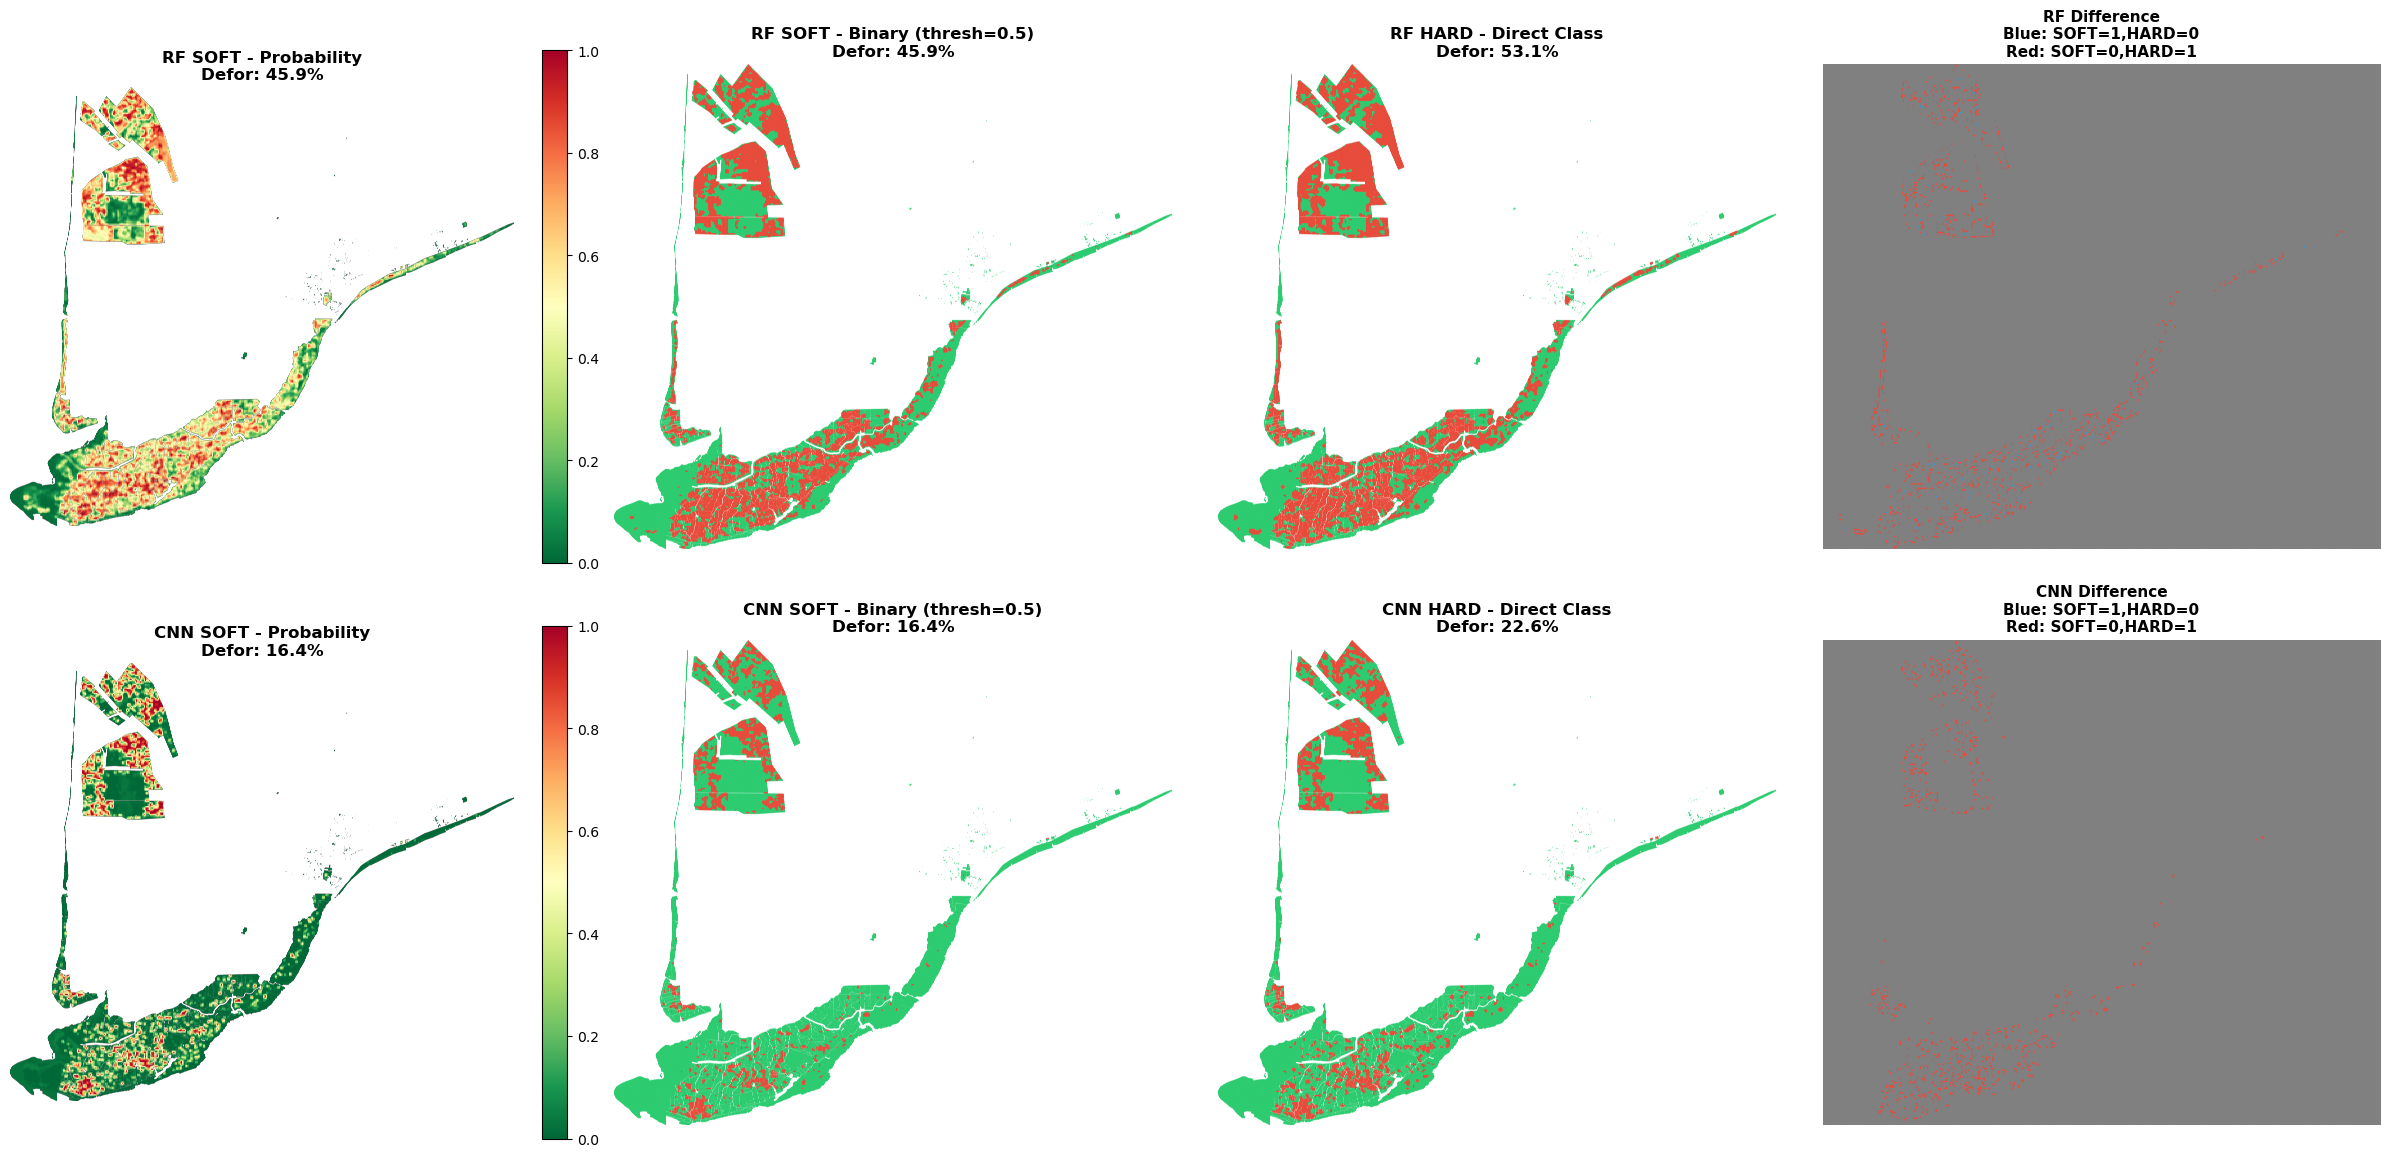


✓ Soft vs Hard comparison saved to: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\figures\soft_vs_hard_comparison.png


In [14]:
if 'rf' in models and 'cnn' in models:
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    
    cmap_binary = ListedColormap(['#2ecc71', '#e74c3c', 'white'])
    
    # Row 1: Random Forest
    # SOFT probability
    ax = axes[0, 0]
    im = ax.imshow(prob_map_rf, cmap='RdYlGn_r', vmin=0, vmax=1)
    ax.set_title(f'RF SOFT - Probability\nDefor: {deforestation_pct_rf:.1f}%', fontsize=12, fontweight='bold')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)
    
    # SOFT binary
    ax = axes[0, 1]
    binary_display = binary_map_rf.copy()
    binary_display[binary_display == 255] = 2
    im = ax.imshow(binary_display, cmap=cmap_binary, vmin=0, vmax=2)
    ax.set_title(f'RF SOFT - Binary (thresh=0.5)\nDefor: {deforestation_pct_rf:.1f}%', fontsize=12, fontweight='bold')
    ax.axis('off')
    
    # HARD binary
    ax = axes[0, 2]
    hard_display = class_map_rf_hard.copy()
    hard_display[hard_display == 255] = 2
    im = ax.imshow(hard_display, cmap=cmap_binary, vmin=0, vmax=2)
    ax.set_title(f'RF HARD - Direct Class\nDefor: {deforestation_pct_rf_hard:.1f}%', fontsize=12, fontweight='bold')
    ax.axis('off')
    
    # Difference (HARD - SOFT)
    ax = axes[0, 3]
    diff_rf = class_map_rf_hard.astype(float) - binary_map_rf.astype(float)
    diff_rf[binary_map_rf == 255] = 0  # Ignore NoData
    cmap_diff = ListedColormap(['#3498db', 'gray', '#e74c3c'])
    im = ax.imshow(diff_rf + 1, cmap=cmap_diff, vmin=0, vmax=2)
    ax.set_title(f'RF Difference\nBlue: SOFT=1,HARD=0\nRed: SOFT=0,HARD=1', fontsize=11, fontweight='bold')
    ax.axis('off')
    
    # Row 2: Simple CNN
    # SOFT probability
    ax = axes[1, 0]
    im = ax.imshow(prob_map_cnn, cmap='RdYlGn_r', vmin=0, vmax=1)
    ax.set_title(f'CNN SOFT - Probability\nDefor: {deforestation_pct_cnn:.1f}%', fontsize=12, fontweight='bold')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)
    
    # SOFT binary
    ax = axes[1, 1]
    binary_display = binary_map_cnn.copy()
    binary_display[binary_display == 255] = 2
    im = ax.imshow(binary_display, cmap=cmap_binary, vmin=0, vmax=2)
    ax.set_title(f'CNN SOFT - Binary (thresh=0.5)\nDefor: {deforestation_pct_cnn:.1f}%', fontsize=12, fontweight='bold')
    ax.axis('off')
    
    # HARD binary
    ax = axes[1, 2]
    hard_display = class_map_cnn_hard.copy()
    hard_display[hard_display == 255] = 2
    im = ax.imshow(hard_display, cmap=cmap_binary, vmin=0, vmax=2)
    ax.set_title(f'CNN HARD - Direct Class\nDefor: {deforestation_pct_cnn_hard:.1f}%', fontsize=12, fontweight='bold')
    ax.axis('off')
    
    # Difference (HARD - SOFT)
    ax = axes[1, 3]
    diff_cnn = class_map_cnn_hard.astype(float) - binary_map_cnn.astype(float)
    diff_cnn[binary_map_cnn == 255] = 0  # Ignore NoData
    im = ax.imshow(diff_cnn + 1, cmap=cmap_diff, vmin=0, vmax=2)
    ax.set_title(f'CNN Difference\nBlue: SOFT=1,HARD=0\nRed: SOFT=0,HARD=1', fontsize=11, fontweight='bold')
    ax.axis('off')
    
    plt.tight_layout()
    output_fig = FIGURES_DIR / "soft_vs_hard_comparison.png"
    plt.savefig(output_fig, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Soft vs Hard comparison saved to: {output_fig}")

## 10. Visualize All Models Side-by-Side

In [15]:
if 'rf' in models and 'cnn' in models:
    fig, axes = plt.subplots(3, 3, figsize=(22, 18))
    
    # Row 1: Random Forest
    # RF Probability Map
    ax = axes[0, 0]
    im = ax.imshow(prob_map_rf, cmap='RdYlGn_r', vmin=0, vmax=1)
    ax.set_title('Random Forest - Probability Map', fontsize=14, fontweight='bold')
    ax.axis('off')
    cbar = plt.colorbar(im, ax=ax, fraction=0.046)
    cbar.set_label('Deforestation Probability')
    
    # RF Binary Map
    ax = axes[0, 1]
    cmap_binary = ListedColormap(['#2ecc71', '#e74c3c', 'white'])
    binary_display_rf = binary_map_rf.copy()
    binary_display_rf[binary_display_rf == 255] = 2
    im = ax.imshow(binary_display_rf, cmap=cmap_binary, vmin=0, vmax=2)
    ax.set_title(f'Random Forest - Binary (threshold={threshold})', fontsize=14, fontweight='bold')
    ax.axis('off')
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, ticks=[0, 1, 2])
    cbar.set_ticklabels(['No Def', 'Def', 'NoData'])
    
    # RF Statistics
    ax = axes[0, 2]
    ax.axis('off')
    rf_stats_text = f"""
RANDOM FOREST
{'='*35}

Inference Time:
  {rf_time/60:.1f} minutes

Deforestation Detected:
  {deforestation_area_ha_rf:.2f} ha
  ({deforestation_area_ha_rf/100:.2f} km²)
  {deforestation_pct_rf:.2f}% of forest

Remaining Forest:
  {forest_area_ha - deforestation_area_ha_rf:.2f} ha
  {100 - deforestation_pct_rf:.2f}%
"""
    ax.text(0.1, 0.5, rf_stats_text, fontsize=12, family='monospace', 
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Row 2: Simple CNN
    # CNN Probability Map
    ax = axes[1, 0]
    im = ax.imshow(prob_map_cnn, cmap='RdYlGn_r', vmin=0, vmax=1)
    ax.set_title('Simple CNN - Probability Map', fontsize=14, fontweight='bold')
    ax.axis('off')
    cbar = plt.colorbar(im, ax=ax, fraction=0.046)
    cbar.set_label('Deforestation Probability')
    
    # CNN Binary Map
    ax = axes[1, 1]
    binary_display_cnn = binary_map_cnn.copy()
    binary_display_cnn[binary_display_cnn == 255] = 2
    im = ax.imshow(binary_display_cnn, cmap=cmap_binary, vmin=0, vmax=2)
    ax.set_title(f'Simple CNN - Binary (threshold={threshold})', fontsize=14, fontweight='bold')
    ax.axis('off')
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, ticks=[0, 1, 2])
    cbar.set_ticklabels(['No Def', 'Def', 'NoData'])
    
    # CNN Statistics
    ax = axes[1, 2]
    ax.axis('off')
    cnn_stats_text = f"""
SIMPLE CNN
{'='*35}

Inference Time:
  {cnn_time/60:.1f} minutes

Deforestation Detected:
  {deforestation_area_ha_cnn:.2f} ha
  ({deforestation_area_ha_cnn/100:.2f} km²)
  {deforestation_pct_cnn:.2f}% of forest

Remaining Forest:
  {forest_area_ha - deforestation_area_ha_cnn:.2f} ha
  {100 - deforestation_pct_cnn:.2f}%
"""
    ax.text(0.1, 0.5, cnn_stats_text, fontsize=12, family='monospace', 
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    # Row 3: Comparison
    # Difference Map (CNN - RF)
    ax = axes[2, 0]
    im = ax.imshow(diff_map, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    ax.set_title('Difference Map (CNN - RF)', fontsize=14, fontweight='bold')
    ax.axis('off')
    cbar = plt.colorbar(im, ax=ax, fraction=0.046)
    cbar.set_label('Probability Difference\n(Red=CNN higher, Blue=RF higher)')
    
    # Agreement/Disagreement Map
    ax = axes[2, 1]
    # Create agreement map: 0=both no, 1=both yes, 2=disagree
    agreement_map = np.zeros_like(binary_map_rf)
    agreement_map[(binary_map_rf == 0) & (binary_map_cnn == 0)] = 0  # Both NO
    agreement_map[(binary_map_rf == 1) & (binary_map_cnn == 1)] = 1  # Both YES
    agreement_map[(binary_map_rf == 0) & (binary_map_cnn == 1)] = 2  # RF=NO, CNN=YES
    agreement_map[(binary_map_rf == 1) & (binary_map_cnn == 0)] = 3  # RF=YES, CNN=NO
    agreement_map[binary_map_rf == 255] = 4  # NoData
    
    cmap_agreement = ListedColormap(['#2ecc71', '#e74c3c', '#f39c12', '#3498db', 'white'])
    im = ax.imshow(agreement_map, cmap=cmap_agreement, vmin=0, vmax=4)
    ax.set_title('Agreement/Disagreement Map', fontsize=14, fontweight='bold')
    ax.axis('off')
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, ticks=[0, 1, 2, 3, 4])
    cbar.set_ticklabels(['Both NO', 'Both YES', 'RF=NO,CNN=YES', 'RF=YES,CNN=NO', 'NoData'])
    
    # Comparison Statistics
    ax = axes[2, 2]
    ax.axis('off')
    comp_stats_text = f"""
COMPARISON
{'='*35}

Agreement:
  {agreement_pct:.2f}% pixels agree
  - Both NO: {agree_both_no_def/forest_area_pixels*100:.1f}%
  - Both YES: {agree_both_def/forest_area_pixels*100:.1f}%

Disagreement:
  {disagreement_pct:.2f}% pixels differ
  - RF=NO, CNN=YES: {disagree_rf_no_cnn_yes/forest_area_pixels*100:.1f}%
  - RF=YES, CNN=NO: {disagree_rf_yes_cnn_no/forest_area_pixels*100:.1f}%

Deforestation Difference:
  RF:  {deforestation_pct_rf:.2f}%
  CNN: {deforestation_pct_cnn:.2f}%
  Δ:   {deforestation_pct_cnn - deforestation_pct_rf:+.2f}%

Speed Comparison:
  RF:  {rf_time/60:.1f} min
  CNN: {cnn_time/60:.1f} min
  CNN is {cnn_time/rf_time:.1f}x slower
"""
    ax.text(0.1, 0.5, comp_stats_text, fontsize=11, family='monospace', 
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))
    
    plt.tight_layout()
    output_fig = FIGURES_DIR / "all_models_comparison_inference.png"
    plt.savefig(output_fig, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Comparison visualization saved to: {output_fig}")

KeyboardInterrupt: 

## 11. Export All Results to GeoTIFF

In [ ]:
# Create output directory
output_dir = PROJECT_ROOT / "predictions"
output_dir.mkdir(exist_ok=True)

print("\n" + "="*70)
print("EXPORTING RESULTS")
print("="*70)

exported_files = []

# Export Random Forest results
if 'rf' in models:
    # Probability map
    rf_prob_output = output_dir / "deforestation_probability_rf.tif"
    with rasterio.open(rf_prob_output, 'w',
                       driver='GTiff',
                       height=prob_map_rf.shape[0],
                       width=prob_map_rf.shape[1],
                       count=1,
                       dtype=prob_map_rf.dtype,
                       crs=profile_s2['crs'],
                       transform=transform,
                       nodata=np.nan) as dst:
        dst.write(prob_map_rf, 1)
    exported_files.append(rf_prob_output)
    
    # Binary map
    rf_binary_output = output_dir / "deforestation_binary_rf.tif"
    with rasterio.open(rf_binary_output, 'w',
                       driver='GTiff',
                       height=binary_map_rf.shape[0],
                       width=binary_map_rf.shape[1],
                       count=1,
                       dtype=binary_map_rf.dtype,
                       crs=profile_s2['crs'],
                       transform=transform,
                       nodata=255) as dst:
        dst.write(binary_map_rf, 1)
    exported_files.append(rf_binary_output)
    
    print(f"\n✓ Random Forest results exported")

# Export Simple CNN results
if 'cnn' in models:
    # Probability map
    cnn_prob_output = output_dir / "deforestation_probability_cnn.tif"
    with rasterio.open(cnn_prob_output, 'w',
                       driver='GTiff',
                       height=prob_map_cnn.shape[0],
                       width=prob_map_cnn.shape[1],
                       count=1,
                       dtype=prob_map_cnn.dtype,
                       crs=profile_s2['crs'],
                       transform=transform,
                       nodata=np.nan) as dst:
        dst.write(prob_map_cnn, 1)
    exported_files.append(cnn_prob_output)
    
    # Binary map
    cnn_binary_output = output_dir / "deforestation_binary_cnn.tif"
    with rasterio.open(cnn_binary_output, 'w',
                       driver='GTiff',
                       height=binary_map_cnn.shape[0],
                       width=binary_map_cnn.shape[1],
                       count=1,
                       dtype=binary_map_cnn.dtype,
                       crs=profile_s2['crs'],
                       transform=transform,
                       nodata=255) as dst:
        dst.write(binary_map_cnn, 1)
    exported_files.append(cnn_binary_output)
    
    print(f"✓ Simple CNN results exported")

# Export difference map
if 'rf' in models and 'cnn' in models:
    diff_output = output_dir / "deforestation_difference_cnn_minus_rf.tif"
    with rasterio.open(diff_output, 'w',
                       driver='GTiff',
                       height=diff_map.shape[0],
                       width=diff_map.shape[1],
                       count=1,
                       dtype=diff_map.dtype,
                       crs=profile_s2['crs'],
                       transform=transform,
                       nodata=np.nan) as dst:
        dst.write(diff_map, 1)
    exported_files.append(diff_output)
    
    print(f"✓ Difference map exported")
    
    # Export agreement map
    agreement_output = output_dir / "agreement_map.tif"
    with rasterio.open(agreement_output, 'w',
                       driver='GTiff',
                       height=agreement_map.shape[0],
                       width=agreement_map.shape[1],
                       count=1,
                       dtype=agreement_map.dtype,
                       crs=profile_s2['crs'],
                       transform=transform,
                       nodata=4) as dst:
        dst.write(agreement_map, 1)
    exported_files.append(agreement_output)
    
    print(f"✓ Agreement map exported")

# Export statistics JSON
results['forest_area_ha'] = float(forest_area_ha)
results['forest_area_km2'] = float(forest_area_ha / 100)
results['threshold'] = threshold

stats_output = output_dir / "all_models_comparison_stats.json"
with open(stats_output, 'w') as f:
    json.dump(results, f, indent=2)
exported_files.append(stats_output)

print(f"✓ Statistics JSON exported")

print("\n" + "="*70)
print(f"ALL {len(exported_files)} FILES EXPORTED:")
print("="*70)
for i, f in enumerate(exported_files, 1):
    print(f"  {i}. {f}")

## 12. Kết luận

✅ **So sánh toàn diện các models đã hoàn thành!**

### Outputs:
1. **Probability Maps** (GeoTIFF) - RF và CNN
2. **Binary Maps** (GeoTIFF) - RF và CNN
3. **Difference Map** (GeoTIFF) - CNN - RF
4. **Agreement Map** (GeoTIFF) - Visualization của agreement/disagreement
5. **Statistics** (JSON) - Tất cả metrics và comparisons
6. **Visualization** (PNG) - Side-by-side 3×3 comparison

### Key Insights:
- **Agreement Rate:** Xem % pixels mà cả 2 models đồng ý
- **Deforestation Estimates:** So sánh diện tích mất rừng giữa RF và CNN
- **Speed:** RF nhanh hơn CNN bao nhiêu lần
- **Spatial Patterns:** Difference map cho thấy vùng nào 2 models khác biệt nhất

### Sử dụng tiếp:
- ✅ Import tất cả GeoTIFFs vào QGIS/ArcGIS
- ✅ Phân tích vùng disagreement để validation
- ✅ Ensemble prediction (average hoặc weighted average)
- ✅ Validate với ground truth mới
- ✅ Time-series analysis nếu có nhiều kỳ ảnh

### Lưu ý:
- ⚠️ Vùng disagreement cao có thể cần thêm ground truth
- ⚠️ Xem xét ensemble approach nếu cả 2 models đều tốt
- ⚠️ So sánh với official forest loss data
- ⚠️ Điều chỉnh threshold nếu cần (hiện tại = 0.5)